In [1]:
# display plots inline
%matplotlib notebook

# imports
import os
import numpy as np
import pandas as pd
import pymc3 as pm
from bambi import Model, Prior
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pymc3_utils as pmu

# suppress system warnings for legibility
import warnings
warnings.filterwarnings('ignore')

# resize plots to fit labels inside bounding box
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# MPI color scheme
sns.set(style='white', palette='Set2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Raven's Progressive Matrices
## Loading data

In [2]:
# start by loading the data
df_ravens = pd.read_csv('data/ravens.tsv', sep='\t').dropna()
df_reading = pd.read_csv('data/tamil_reading.tsv', sep='\t').drop(columns=['literate', 'subject'])
df_ravens = df_ravens.merge(df_reading, left_on='pp', right_on='pp')

display(df_ravens.head())

,Unnamed: 0,item,RT,ACC,literate,number,list,pp,subject,word,pseudoword
0,1,A11.jpg,18.244568,0.0,low,1,a,low_1,1,24,1
1,2,B12.jpg,56.643328,0.0,low,1,a,low_1,1,24,1
2,3,C4.jpg,18.877469,0.0,low,1,a,low_1,1,24,1
3,4,C12.jpg,11.292590,0.0,low,1,a,low_1,1,24,1
4,5,D7.jpg,19.145151,0.0,low,1,a,low_1,1,24,1


## Data mangling and plotting

In [3]:
# standardize reading score
df_ravens['reading_z'] = pmu.standardize(df_ravens['word'])

display(df_ravens.head())

,Unnamed: 0,item,RT,ACC,literate,number,list,pp,subject,word,pseudoword,reading_z
0,1,A11.jpg,18.244568,0.0,low,1,a,low_1,1,24,1,-0.328913
1,2,B12.jpg,56.643328,0.0,low,1,a,low_1,1,24,1,-0.328913
2,3,C4.jpg,18.877469,0.0,low,1,a,low_1,1,24,1,-0.328913
3,4,C12.jpg,11.292590,0.0,low,1,a,low_1,1,24,1,-0.328913
4,5,D7.jpg,19.145151,0.0,low,1,a,low_1,1,24,1,-0.328913


In [4]:
display(df_ravens.groupby('literate').mean())

,Unnamed: 0,RT,ACC,number,subject,word,pseudoword,reading_z
literate,,,,,,,,
low,5.0,15.598246,0.194444,15.500000,50.100000,38.100000,21.100000,0.175868
n,5.0,11.620459,0.124183,18.117647,58.970588,3.411765,0.735294,-1.065972
y,5.0,22.217346,0.333333,16.500000,36.937500,60.218750,39.375000,0.967719


## Modeling

In [5]:
display(df_ravens.groupby('literate').std())

,Unnamed: 0,RT,ACC,number,subject,word,pseudoword,reading_z
literate,,,,,,,,
low,2.584383,13.367629,0.396139,8.663467,21.522418,18.507412,13.528819,0.662566
n,2.584101,15.489165,0.330060,10.473529,28.925591,5.941371,1.704484,0.212701
y,2.584233,21.627293,0.471814,9.241118,28.257873,16.929441,14.122877,0.606074


First we will set some parameters for the regression procedure, as outlined in the paper.

In [6]:
# Default model params
defaults = {
    'samples': 5000,
    'tune': 2500,
    'chains': 4,
    'init': 'advi+adapt_diag',
    'family': 'bernoulli',
    'priors': {'fixed': 'narrow', 'random': 'narrow'},
}

We are modelling each question in the ravens task as a Bernoulli trial (i.e., a generalized linear model). We will run the only model that works in the context of our multilevel model setup: A model with no fixed effects, only an overall intercept and by-participant and by-item intercepts.

In [7]:
model_ravens_intercept = Model(df_ravens)
model_ravens_intercept.fit('ACC ~ 1',
                           random=['1|item', '1|pp'],
                           **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 826.4:  32%|███▏      | 15999/50000 [00:10<00:23, 1468.98it/s] 
Convergence achieved at 16000
Interrupted at 15,999 [31%]: Average Loss = 869.04
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|pp_offset, 1|pp_sd, 1|item_offset, 1|item_sd, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [01:02<00:00, 480.50draws/s]


In [8]:
display(pm.summary(model_ravens_intercept.backend.trace).round(2))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],-1.61,0.22,-2.03,-1.20,0.0,0.0,8099.0,8075.0,8111.0,11884.0,1.0
1|item_offset[0],1.47,0.42,0.69,2.25,0.0,0.0,12348.0,12348.0,12319.0,14723.0,1.0
1|item_offset[1],-0.48,0.43,-1.33,0.31,0.0,0.0,15653.0,13462.0,15615.0,14440.0,1.0
1|item_offset[2],-0.10,0.41,-0.83,0.71,0.0,0.0,14708.0,11377.0,14745.0,14244.0,1.0
1|item_offset[3],2.35,0.49,1.44,3.25,0.0,0.0,11675.0,11675.0,11611.0,14377.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1|pp[91],0.09,0.51,-0.87,1.06,0.0,0.0,36821.0,8144.0,37753.0,13884.0,1.0
1|pp[92],0.10,0.51,-0.87,1.03,0.0,0.0,41285.0,7937.0,41790.0,14601.0,1.0
1|pp[93],1.19,0.46,0.33,2.05,0.0,0.0,39198.0,30831.0,39165.0,14767.0,1.0
1|pp[94],0.34,0.50,-0.62,1.25,0.0,0.0,42028.0,12647.0,42586.0,13758.0,1.0


\\(\hat{r}\\) values look good, as does the number of effective samples for the by-participant intercepts. Even for the overall intercept we have 8.5K effective samples.

## Plot model traces

As an additional check, we will plot the posterior traces for the selected model. Ideally these look unimodal and roughly normal. The plots on the righthand side should look like fuzzy caterpillars.

<IPython.core.display.Javascript object>


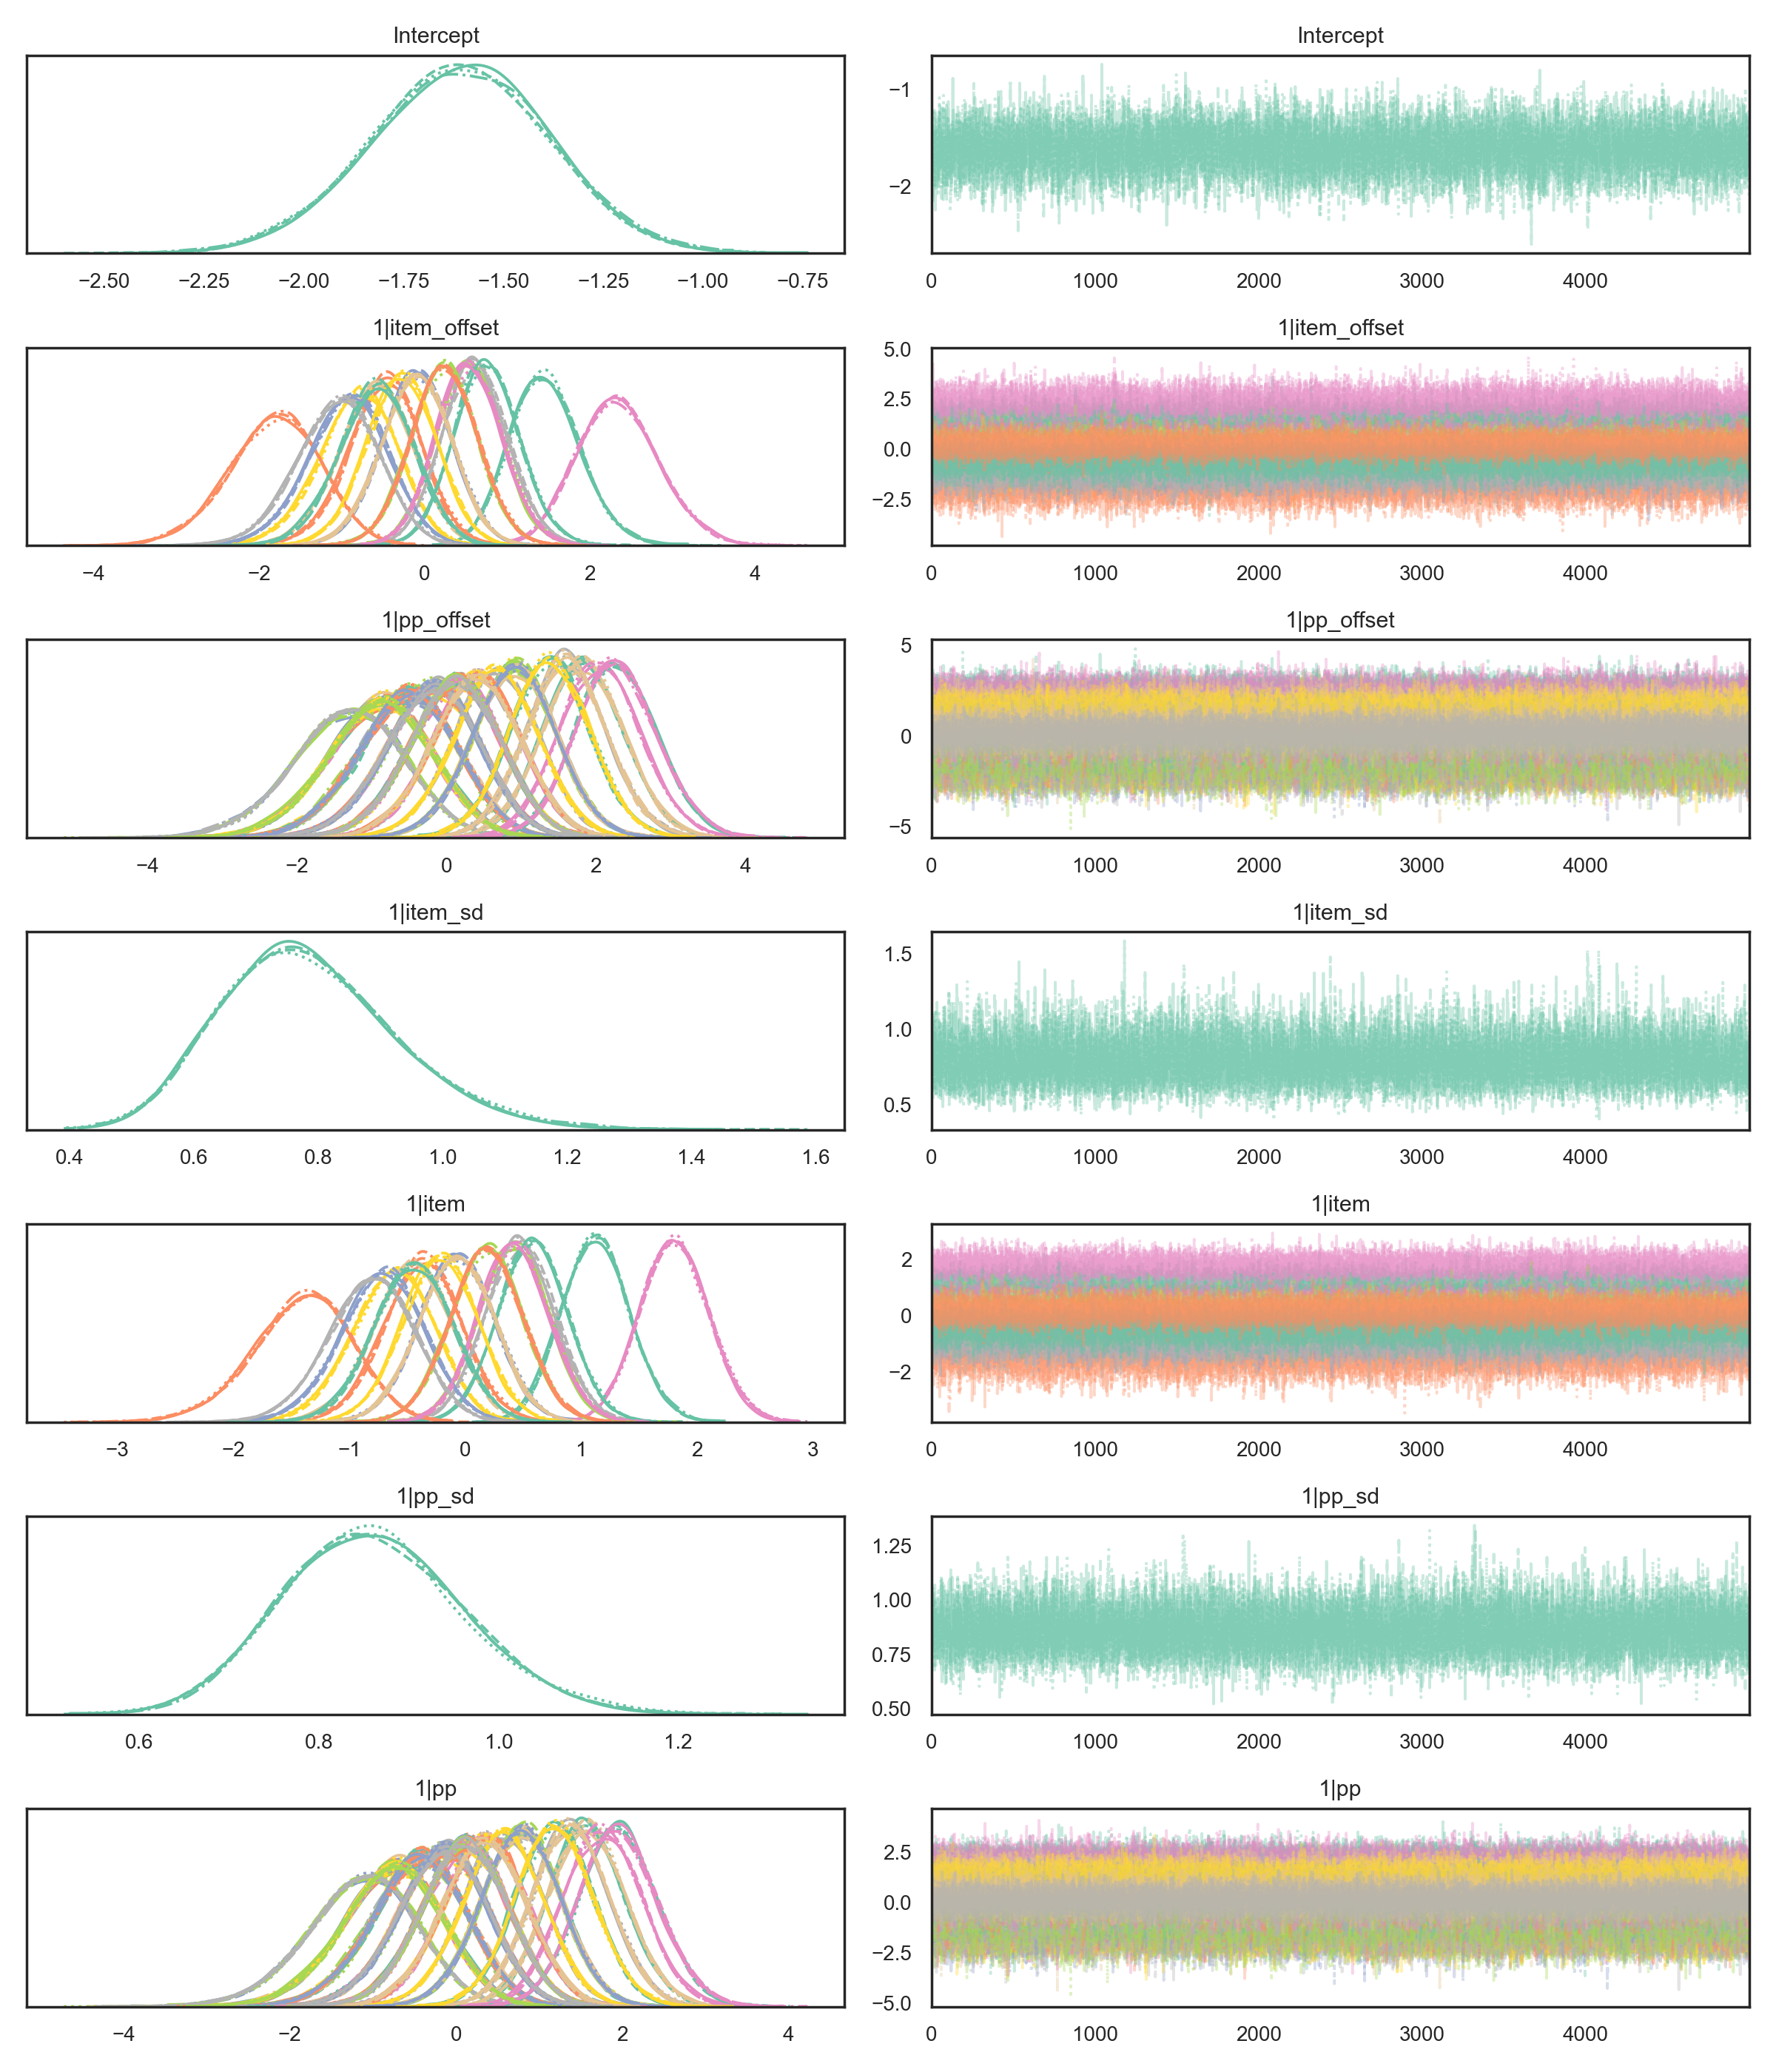

In [9]:
g_traces = pm.traceplot(model_ravens_intercept.backend.trace)
plt.savefig('figures/ravens_model_traces.png', dpi=600)

## Extracting participant intercept modes

We will now extract and store the posterior means of the participant intercepts so we can use them to model reading scores.

In [10]:
pps = df_ravens['pp'].unique()
pp_nums = [f'1|pp[{i}]' for i in range(len(pps))]
df_intercepts = pm.summary(model_ravens_intercept.backend.trace).loc[pp_nums]
df_intercepts['pp'] = np.sort(pps)

display(df_intercepts.head().round(2))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,pp
1|pp[0],0.34,0.49,-0.61,1.25,0.0,0.0,42146.0,12290.0,42831.0,13118.0,1.0,low_1
1|pp[1],-0.17,0.53,-1.16,0.84,0.0,0.0,41323.0,8301.0,42602.0,14168.0,1.0,low_10
1|pp[2],0.10,0.50,-0.84,1.04,0.0,0.0,44113.0,8206.0,45021.0,14269.0,1.0,low_11
1|pp[3],0.34,0.49,-0.54,1.28,0.0,0.0,37320.0,12690.0,38369.0,12784.0,1.0,low_12
1|pp[4],-0.46,0.55,-1.49,0.57,0.0,0.0,43143.0,14458.0,44474.0,14810.0,1.0,low_13


In [11]:
df_uncorrected = df_ravens.groupby('pp', as_index=False).mean().rename(columns={'ACC': 'raw_ravens_mean'})
df_intercepts = df_intercepts[['pp', 'mean']].rename(columns={'mean': 'ravens_intercept'})
df_intercepts = df_intercepts.merge(df_uncorrected[['pp', 'reading_z', 'raw_ravens_mean']],
                                    left_on='pp', right_on='pp').reset_index()

display(df_intercepts.head().round(2))

,index,pp,ravens_intercept,reading_z,raw_ravens_mean
0,0,low_1,0.34,-0.33,0.28
1,1,low_10,-0.17,0.64,0.17
2,2,low_11,0.10,0.35,0.22
3,3,low_12,0.34,-0.01,0.28
4,4,low_13,-0.46,-0.01,0.11


In [12]:
# and write to file
df_intercepts.to_csv('data/ravens_intercepts.tsv', sep='\t')

Before closing this notebook, we will take a quick look at the correlations between ravens score and reading score.

In [13]:
display(df_intercepts[['raw_ravens_mean', 'ravens_intercept', 'reading_z']].corr().round(2))

,raw_ravens_mean,ravens_intercept,reading_z
raw_ravens_mean,1.00,0.99,0.53
ravens_intercept,0.99,1.00,0.52
reading_z,0.53,0.52,1.00


Apparently it makes no difference whether we use the participant intercepts from our span model or the mean of forward and backward digit span for each individual participant, since the correlation between these variables is nearly 1.